In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rc, cm
from matplotlib.ticker import FixedLocator
import os.path as osp
import os
import cartopy.crs as ccrs
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point, LineString, Polygon
from shapely import geometry
from cartopy.feature import ShapelyFeature
import networkx as nx
import itertools as it
from PIL import ImageColor
import pickle5 as pickle

In [3]:
plt.rcParams.update({"font.size": 12})

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])

dpi = 200

cmap = cm.get_cmap('YlOrRd')
c_traj = '#cc2900'
c_radar_loc = '#A50026'
c_radar_area = '#347B98'
c_boundary_light = '#0a3142'
c_boundary = '#092834'
c_text = '#262626'
c_countries = 'lightgray'

In [4]:
home = osp.expanduser("~")
base_dir = osp.join(home, 'FluxRGNN')
target_dir = osp.join(base_dir, 'data', 'plots', 'final')
abm_path = osp.join(base_dir, 'data', 'raw', 'abm', 'fall', '2015')

In [4]:
voronoi_b = gpd.read_file(osp.join(base_dir, 'data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2015/voronoi.shp'))
voronoi_b = voronoi_b.to_crs(epsg=4326)

countries = gpd.read_file(osp.join(base_dir, 'data/shapes/ne_10m_admin_0_countries_lakes.shp'))
target_area_df = gpd.read_file(osp.join(base_dir, 'data/shapes/target_area.shp'))
target_area = target_area_df.iloc[0].geometry

extent = voronoi_b.total_bounds
extent[1] -= 1.0
extent[3] += 2.0
crs = ccrs.AlbersEqualArea(central_longitude=voronoi_b.lon.mean(), central_latitude=voronoi_b.lat.mean())

radar_buffers_b = gpd.read_file(osp.join(root, 'data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2015/radar_buffers.shp'))
radars_b = radar_buffers_b.to_crs(crs.proj4_init).centroid.to_crs(epsg=4326)


In [5]:
file = osp.join(abm_path, 'simulation_results_1.pkl')
with open(file, 'rb') as f:
    result = pickle.load(f)
    traj = result['trajectories']
    states = result['states']
    time = result['time']

In [6]:
T, B, _ = traj.shape

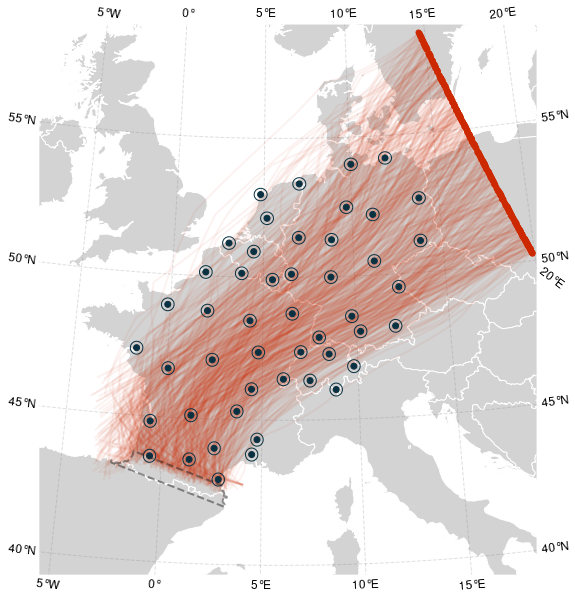

In [29]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')
gl.xlocator = xspacing
gl.ylocator = yspacing

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0)

tr_alpha = 0.06

birds = range(0, 500)
for bidx in birds:
    traj_b = traj[:, bidx]
    for t in range(traj_b.shape[0]-1):
        lon1, lat1 = traj_b[t]
        lon2, lat2 = traj_b[t+1]
        path = LineString([Point(lon1, lat1), Point(lon2, lat2)])
        arrived = path.intersects(target_area)
        if arrived:
            traj_b[t+1:, 0] = lon2
            traj_b[t+1:, 1] = lat2
            break
    xx = traj_b[..., 0]
    yy = traj_b[..., 1]
    tr = LineString([Point(x, y) for x, y in zip(xx, yy)])
    start = Point(xx[0], yy[0])
    gplt.polyplot(gpd.GeoSeries(tr, crs='epsg:4326'), ax=ax, zorder=2, 
                  alpha=tr_alpha, edgecolor=c_traj, linewidth=2, extent=extent)
    gplt.pointplot(gpd.GeoSeries(start, crs='epsg:4326'), ax=ax, zorder=3, extent=extent, color=c_traj)

gplt.pointplot(radars_b[voronoi_b.query('observed == 1').index], ax=ax, 
               extent=extent, zorder=3, color=c_boundary_light, s=6)
gplt.polyplot(radar_buffers_b.query('observed == 1'), ax=ax, extent=extent, 
              zorder=3, edgecolor=c_boundary_light, linewidth=1)

ax = gplt.polyplot(target_area_df, edgecolor=c_text, linestyle='--', alpha=0.5,
                linewidth=2, ax=ax, zorder=4, extent=extent)

fig.tight_layout()
fig.savefig(osp.join(target_dir, 'abm_trajectories_filtered.png'), bbox_inches='tight', dpi=100)

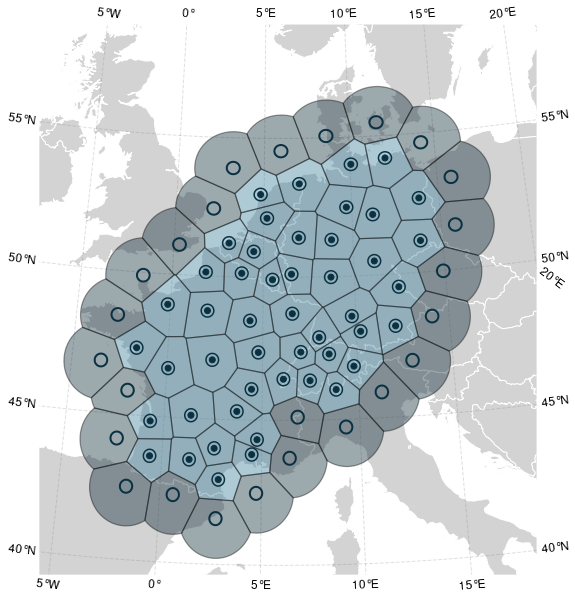

In [9]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')
gl.xlocator = xspacing
gl.ylocator = yspacing

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0)
gplt.polyplot(voronoi_b.query('observed == 0'), ax=ax, facecolor=c_boundary, 
              alpha=0.4, linewidth=1.2, extent=extent, zorder=2)
gplt.polyplot(voronoi_b.query('observed == 1'), ax=ax, facecolor=c_radar_area, 
              alpha=0.4, linewidth=1.2, extent=extent, zorder=2)
a = gplt.polyplot(radar_buffers_b.query('observed == 1'), ax=ax, extent=extent, 
                  zorder=3, edgecolor=c_boundary_light, linewidth=1.5)
b = gplt.polyplot(radar_buffers_b.query('observed == 0'), ax=ax, extent=extent, 
                  zorder=3, edgecolor=c_boundary_light, linewidth=2)


gplt.pointplot(radars_b[voronoi_b.query('observed == 1').index], ax=ax, extent=extent, 
               zorder=3, color=c_boundary_light, s=6)

fig.tight_layout()

fig.savefig(osp.join(target_dir, 'voronoi_tessellation_abm.png'), bbox_inches='tight', dpi=200)

In [5]:
features = pd.read_csv(osp.join(base_dir, 
            'data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2017/dynamic_features.csv'))
total_birds = features.groupby('tidx').birds.aggregate(sum).reset_index()

def get_month(dts):
    return pd.DatetimeIndex(dts)[0].month
months = features.groupby('tidx').datetime.aggregate(get_month).reset_index()

birds_per_month = {}
N = total_birds.birds.sum()
for m in months.datetime.unique():
    idx = np.where(months.datetime.values == m)
    birds_per_month[m] = total_birds.birds.values[idx].sum() / N
    
print('###### birds per month #######')
print(birds_per_month)

###### birds per month #######
{8: 0.02640949364516881, 9: 0.6882809876881161, 10: 0.17567023526669331, 11: 0.10963928340002181}


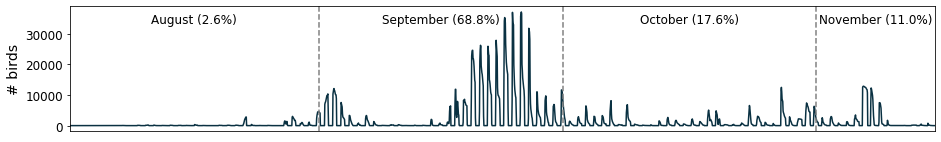

In [11]:
fig, ax = plt.subplots(figsize=(15.5,2.3))
ax.plot(total_birds.birds.values, lw=1.5, c='#0a3142')
ax.set(xticks=[])
ax.set_ylabel('# birds', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

m = months.datetime.values
switches = np.where(m[1:] - m[:-1] == 1)[0]

prev = 0
month_labels = ['August (2.6%)', 'September (68.8%)', 'October (17.6%)', 'November (11.0%)']
for i, s in enumerate(switches):
    ax.axvline(s+0.5, ls='--', c='gray')
    plt.annotate(month_labels[i], ((prev+s)/2, total_birds.birds.max()*0.9), 
                 xycoords='data', ha='center', fontsize=12)
    prev = s
plt.annotate(month_labels[-1], ((prev+months.tidx.max())/2, total_birds.birds.max()*0.9), 
             xycoords='data', ha='center', fontsize=12)

ax.set_xlim(0, months.tidx.max())
fig.savefig(osp.join(target_dir, 'abm_birds_time_series.png'), bbox_inches='tight', dpi=200)